Import packagaes

In [1]:
import random, dateutil.parser
from datetime import datetime, timedelta

Define data structures

In [2]:
userTwabs = []

Twab = {
    "amount": None,
    "timestamp": None
}


Generate random Twabs

In [3]:
# Define the current timestamp
now = datetime.now()

# Define the timestamp two weeks ago
two_weeks_ago = now - timedelta(weeks=2)

# Define a function to generate a random timestamp within the last two weeks
def generate_random_timestamp():
    random_timestamp = two_weeks_ago + (now - two_weeks_ago) * random.random()
    return int(random_timestamp.timestamp())

# Generate a list of 10 random timestamps within the last two weeks
random_timestamps = [generate_random_timestamp() for _ in range(10)]

for timestamp in random_timestamps:
    print(timestamp)


1691575643
1691546442
1691194256
1690894063
1691723658
1692043138
1691532072
1691228781
1690969202
1691696753


Now let's populate `userTwabs` with our randomised values

In [4]:
# Initial balance
balance = 0

# Define a function to generate a random balance change with 1dp precision between -0.2 and 0.2 ETH
def adjust_balance():
    global balance
    # Generate a random balance adjustment
    adjustment = round(random.uniform(-0.2, 1), 1)

    # Add the adjustment to the current balance, ensuring it doesn't go below 0
    balance = round(max(0, balance + adjustment),1)
    return balance

In [5]:
# Define a function to generate a random balance with 1dp precision between 0 and 2 ETH
def generate_random_balance():
    return round(random.uniform(0, 2), 1)

# Generate a list of 10 random Twabs within the last two weeks
userTwabs = [{"amount": adjust_balance(), "timestamp": generate_random_timestamp()} for _ in range(10)]

# Sort the list of Twabs by timestamp
userTwabs.sort(key=lambda twab: twab["timestamp"])

for twab in userTwabs:
    print(twab)


{'amount': 5.3, 'timestamp': 1690947338}
{'amount': 5.7, 'timestamp': 1691121983}
{'amount': 1.3, 'timestamp': 1691149440}
{'amount': 2.8, 'timestamp': 1691461375}
{'amount': 3.7, 'timestamp': 1691525581}
{'amount': 2.0, 'timestamp': 1691664789}
{'amount': 3.5, 'timestamp': 1691705348}
{'amount': 0.4, 'timestamp': 1691737711}
{'amount': 4.5, 'timestamp': 1691741438}
{'amount': 6.0, 'timestamp': 1691845331}


Function to return timestamp from datetime string

In [6]:
def convert_to_timestamp(datetime_string):
    # Parse the datetime string
    dt = dateutil.parser.parse(datetime_string)

    # Convert to a Unix timestamp
    timestamp = int(dt.timestamp())
    
    return timestamp

In [8]:
startTime = convert_to_timestamp('Sat 5th August 2023 13:00')
endTime = convert_to_timestamp('Sat 12nd August 2023 13:00')

print('Raffle times:')
print(f'Start: {startTime}')
print(f'End: {endTime}')

Raffle times:
Start: 1691236800
End: 1691841600


Now, let's write a formula for calculating the average `amount` held by a user between the timestamps `startTime` and `endTime`.

The random values we created represent snapshots of a user's balance, these snapshots are taken whenever a change of balance occurs. Therefore, we can assume the balance before the first timestamp is 0, and we can assume the balance after the last timestamp is same as the balance at that last timestamp.

First, let's write a function for finding the index of the dictionary (in the `userTwabs` array) that contains the amount and timestamp immediately preceding `startTime`.

**Binary search**:
- efficient algorithm for finding an item from a sorted list of items
    - `userTwabs` is the list of TWABs sorted in ascending order by timestamp
- works by repeatedly dividing the search interval in half.
1. Start with the middle item: If the target value is equal to the middle item of the array, then return the index of the middle item.
2. If the target value is less than the middle item, continue the search in the lower half of the array. Ignore the upper half of the array since the target value, being smaller than the middle item, can't be in the upper half.
3. If the target value is greater than the middle item, do the opposite. Continue the search in the upper half of the array and ignore the lower half.
4. Repeat these steps until the target value is found or until the subarray is empty (i.e., the start index is greater than the end index).

In [9]:
def find_preceding_timestamp_index(user_twabs, startTime):
    start = 0
    end = len(user_twabs) - 1

    while start <= end:
        mid = start + (end - start) // 2

        if user_twabs[mid]['timestamp'] < startTime:
            if mid + 1 < len(user_twabs) and user_twabs[mid + 1]['timestamp'] >= startTime:
                return mid
            start = mid + 1
        else:
            end = mid - 1
    return None

Why use binary search? Efficiency: In a list of n items, binary search can find a target value in at most log2(n) steps, which is significantly faster than a linear search, especially for large lists. This is because with each step, binary search reduces the size of the search space by half.

In [10]:
index = find_preceding_timestamp_index(userTwabs, startTime)
print(index)

2


Now let's calculate the average balance of the user between startTime and endTime. We can iterate through the sorted `userTwabs` array and sum up the products of each balance and the duration it was held. Then, divide that sum by the total duration between startTime and endTime.

Since we are linearly extrapolating balances, if startTime or endTime falls between two balance timestamps, we will assume that the balance changes linearly between the two timestamps.

In [11]:
def calculate_average_balance(user_twabs, startTime, endTime):
    # Find the index of the timestamp immediately preceding the startTime
    preceding_index = find_preceding_timestamp_index(user_twabs, startTime)

    # Initialise variables
    total_balance_duration = 0.0
    prev_timestamp = startTime
    prev_balance = 0.0 if preceding_index is None else user_twabs[preceding_index]['amount']

    for twab in user_twabs[preceding_index + 1:]:
        if twab['timestamp'] > endTime:
            break

        duration = twab['timestamp'] - prev_timestamp
        total_balance_duration += prev_balance * duration

        prev_timestamp = twab['timestamp']
        prev_balance = twab['amount']

    # Add the balance_duration for the last part
    final_duration = endTime - prev_timestamp
    total_balance_duration += prev_balance * final_duration

    return total_balance_duration / (endTime - startTime)

average_balance = calculate_average_balance(userTwabs, startTime, endTime)

print(f'The average balance between {startTime} and {endTime} is {average_balance:.4f} ETH.')

The average balance between 1691236800 and 1691841600 is 2.7007 ETH.


1. Initialise necessary variables: The function initialises some necessary variables - total_balance_duration is set to 0.0, it will accumulate the total time-weighted balance, and prev_timestamp and prev_balance are set to the timestamp and balance just before the startTime. If there's no such timestamp (i.e., startTime is before all recorded timestamps), prev_balance is assumed to be 0.0.

2. Iterate through TWABs: The function then iterates over the list of `userTwabs`, starting from the first timestamp after startTime.

3. Calculate the balance duration for each interval: For each timestamp, the function calculates the duration that the previous balance was held (i.e., the difference in timestamps) and adds the product of the balance and the duration to total_balance_duration. This is based on the assumption that the balance remained constant during each interval between two timestamps.

4. Update the previous timestamp and balance: The prev_timestamp and prev_balance variables are updated for the next iteration.

5. Break when the timestamp exceeds endTime: The loop breaks when a timestamp is found that exceeds the endTime. This ensures that balances held after the endTime are not included in the calculation.

6. Handle the final interval: After breaking the loop, the function handles the final interval from the last timestamp to endTime. It assumes that the balance remained constant during this interval and adds the product of the balance and the duration to total_balance_duration.

7. Calculate and return the average balance: Finally, the function calculates the average balance by dividing total_balance_duration by the total duration between startTime and endTime.

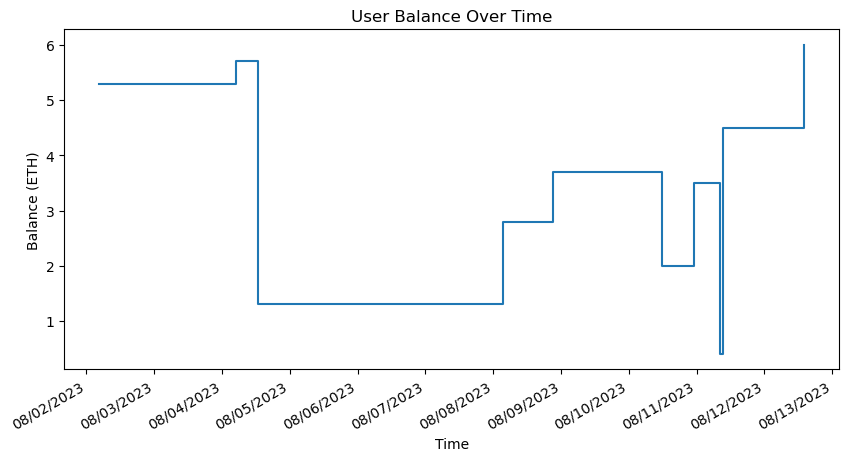

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the Unix timestamps to datetime objects for easier plotting
timestamps = [datetime.fromtimestamp(twab['timestamp']) for twab in userTwabs]
balances = [twab['amount'] for twab in userTwabs]

plt.figure(figsize=(10,5))

# Plot the data as a step plot
plt.step(timestamps, balances, where='post')

# Format the x-axis to display dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

# Set the title and labels
plt.title('User Balance Over Time')
plt.xlabel('Time')
plt.ylabel('Balance (ETH)')

# Display the plot
plt.show()


In [22]:
import altair as alt
import pandas as pd

# Convert the Unix timestamps to datetime objects for easier plotting
timestamps = [pd.to_datetime(twab['timestamp'], unit='s') for twab in userTwabs]
balances = [twab['amount'] for twab in userTwabs]

# Create a dataframe from the timestamps and balances
df = pd.DataFrame({'Time': timestamps, 'Balance': balances})

# Create the base line chart
base = alt.Chart(df).mark_line(interpolate='step-after').encode(
    x= alt.X('Time:T', axis=alt.Axis(format='%a %d', title='Time')),
    y='Balance:Q'
).properties(
    title='User Balance Over Time',
    width=600
)

# Add vertical dashed lines for the start and end times of the raffle
start_time = pd.to_datetime(startTime, unit='s')
end_time = pd.to_datetime(endTime, unit='s')
start_line = alt.Chart(pd.DataFrame({'Time': [start_time]})).mark_rule(color='red', strokeDash=[5,5]).encode(x='Time:T')
end_line = alt.Chart(pd.DataFrame({'Time': [end_time]})).mark_rule(color='red', strokeDash=[5,5]).encode(x='Time:T')

# Combine the line chart and the vertical lines
chart = alt.layer(base, start_line, end_line)

# Display the chart
chart

alt.LayerChart(...)